# Hybrid Search: Combining Dense and Sparse Retrieval

In this notebook, we'll explore hybrid search techniques that combine dense and sparse retrieval methods for superior search quality in production RAG systems.

## Learning Objectives
By the end of this notebook, you will:
1. Understand why hybrid search outperforms single methods
2. Implement hybrid search combining dense and sparse retrieval
3. Learn to tune hybrid search parameters effectively
4. Explore query expansion and reformulation strategies
5. Build a complete retrieval pipeline with multiple strategies
6. Understand performance trade-offs and optimization techniques


In [2]:
# Standard library imports
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Any
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
import sys
sys.path.append(str(Path.cwd().parent))

# Import our modules
try:
    from src.retrieval.retrieval_system import RetrievalSystem, RetrievalConfig
    from src.models.embedding_models import BGEEmbeddingModel, E5EmbeddingModel
    from src.models.reranker_models import BGEReranker
    from src.config import DATA_DIR
except ImportError as e:
    print(f"Import error: {e}")
    print("Creating fallback implementations...")
    
    # Fallback configuration
    DATA_DIR = Path("data")
    
    class RetrievalConfig:
        def __init__(self):
            self.top_k = 10
            self.rerank_top_k = 5
            self.similarity_threshold = 0.7
            self.hybrid_alpha = 0.7
            self.hybrid_beta = 0.3
            self.use_reranking = True

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print(" Libraries imported successfully!")
print(f" Data directory: {DATA_DIR}")

# Load sample data
processed_dir = DATA_DIR / "processed"
chunks_file = processed_dir / "all_chunks.json"

if chunks_file.exists():
    print(f" Loading processed chunks from {chunks_file}")
    with open(chunks_file, 'r', encoding='utf-8') as f:
        all_chunks = json.load(f)
    print(f" Loaded {len(all_chunks)} chunks")
else:
    print(" No processed chunks found. Creating sample data...")
    all_chunks = [
        {
            'id': 'chunk1',
            'text': 'Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.',
            'title': 'Machine Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_1'
        },
        {
            'id': 'chunk2', 
            'text': 'Deep learning uses neural networks with multiple layers to process data and make predictions.',
            'title': 'Deep Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_2'
        },
        {
            'id': 'chunk3',
            'text': 'Natural language processing helps computers understand, interpret, and generate human language.',
            'title': 'NLP',
            'source': 'wikipedia',
            'chunk_id': 'chunk_3'
        },
        {
            'id': 'chunk4',
            'text': 'Computer vision enables machines to interpret and understand visual information from the world.',
            'title': 'Computer Vision',
            'source': 'wikipedia',
            'chunk_id': 'chunk_4'
        },
        {
            'id': 'chunk5',
            'text': 'Reinforcement learning is a type of machine learning where agents learn through interaction with an environment.',
            'title': 'Reinforcement Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_5'
        }
    ]
    print(f" Created {len(all_chunks)} sample chunks")
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load sample data
chunks_file = DATA_DIR / "processed" / "all_chunks.json"
if chunks_file.exists():
    with open(chunks_file, 'r', encoding='utf-8') as f:
        all_chunks = json.load(f)
    print(f"Loaded {len(all_chunks)} chunks from previous notebook")
else:
    print("Creating sample data...")
    all_chunks = [
        {
            'id': 'chunk1',
            'text': 'Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.',
            'title': 'Machine Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_1'
        },
        {
            'id': 'chunk2',
            'text': 'Deep learning uses neural networks with multiple layers to process complex data patterns.',
            'title': 'Deep Learning', 
            'source': 'wikipedia',
            'chunk_id': 'chunk_2'
        },
        {
            'id': 'chunk3',
            'text': 'Natural language processing is a field of AI that focuses on the interaction between computers and human language.',
            'title': 'NLP',
            'source': 'wikipedia',
            'chunk_id': 'chunk_3'
        },
        {
            'id': 'chunk4',
            'text': 'Computer vision is a field of artificial intelligence that trains computers to interpret and understand visual information.',
            'title': 'Computer Vision',
            'source': 'wikipedia',
            'chunk_id': 'chunk_4'
        },
        {
            'id': 'chunk5',
            'text': 'Reinforcement learning is a type of machine learning where agents learn to make decisions through trial and error.',
            'title': 'Reinforcement Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_5'
        }
    ]
    print(f"Created {len(all_chunks)} sample chunks")


 Libraries imported successfully!
 Data directory: /Users/scienceman/Desktop/LLM/data
 Loading processed chunks from /Users/scienceman/Desktop/LLM/data/processed/all_chunks.json
 Loaded 18 chunks
Libraries imported successfully!
Loaded 18 chunks from previous notebook


## Building Advanced Retrieval Systems

Let's build a comprehensive retrieval system that combines multiple strategies for better results.


### Understanding Hybrid Search

Hybrid search combines multiple retrieval methods to achieve better results than any single method alone. This is the foundation of modern production RAG systems.

#### Why Hybrid Search Works

**The Problem with Single Methods**:
- **Dense Retrieval**: Great for semantic understanding but can miss exact keyword matches
- **Sparse Retrieval**: Great for exact term matching but struggles with semantic similarity
- **Neither alone**: Often misses relevant documents that the other method would find

**The Hybrid Solution**:
- **Combines Strengths**: Uses both dense and sparse retrieval
- **Better Coverage**: Finds documents that either method alone might miss
- **Tunable Balance**: Adjust weights based on your specific use case
- **Proven Results**: Typically 10-30% better performance than single methods

#### The Hybrid Search Formula

```
Final Score = α × Dense_Score + β × Sparse_Score
```

Where:
- **α (alpha)**: Weight for dense retrieval (typically 0.6-0.8)
- **β (beta)**: Weight for sparse retrieval (typically 0.2-0.4)
- **α + β = 1.0**: Ensures balanced scoring

#### When to Use Hybrid Search

**Best For**:
- Production RAG systems where quality matters
- Diverse document collections with varied content types
- Queries that mix semantic and keyword elements
- When you need both recall and precision

**Trade-offs**:
- **Pros**: Better quality, more comprehensive results
- **Cons**: Higher computational cost, more complex tuning

#### Tuning Hybrid Search Parameters

**Alpha (Dense Weight)**:
- **Higher (0.7-0.8)**: When semantic understanding is more important
- **Lower (0.5-0.6)**: When exact keyword matching is critical

**Beta (Sparse Weight)**:
- **Higher (0.4-0.5)**: When documents contain specific technical terms
- **Lower (0.2-0.3)**: When content is more conceptual

**Best Practice**: Start with α=0.7, β=0.3 and adjust based on your evaluation metrics.


### Understanding Query Expansion

Query expansion helps bridge the gap between how users ask questions and how information is written in documents.

#### The Query Understanding Problem

**Why Queries Fail**:
- **Vocabulary Mismatch**: Users say "AI" but documents say "artificial intelligence"
- **Question Style**: Users ask "How does ML work?" but documents explain "Machine learning is..."
- **Technical Terms**: Users use abbreviations that documents spell out
- **Context Missing**: Users don't know the right domain terms

#### Query Expansion Techniques

**1. Synonym Expansion**:
- "car" → "automobile", "vehicle", "auto"
- "AI" → "artificial intelligence", "machine intelligence"
- "ML" → "machine learning", "statistical learning"

**2. Question Reformulation**:
- "How does X work?" → "What is X?", "Explain X"
- "Tell me about Y" → "Define Y", "Y definition"

**3. Context Addition**:
- Add domain-specific terms from related documents
- Include technical terminology
- Expand acronyms and abbreviations

#### When to Use Query Expansion

**Best For**:
- Diverse user base with varying technical knowledge
- Documents with technical terminology
- When recall is more important than precision
- Complex domain-specific content

**Trade-offs**:
- **Pros**: Better recall, handles vocabulary mismatch
- **Cons**: Can introduce noise, more complex implementation


In [3]:
# Import required libraries for our retrieval system
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import Counter

class AdvancedRetrievalSystem:
    """Advanced retrieval system with multiple strategies."""
    
    def __init__(self, embedding_model='all-MiniLM-L6-v2'):
        """Initialize the retrieval system."""
        self.embedding_model = SentenceTransformer(embedding_model)
        self.tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        
        # Storage for documents and embeddings
        self.documents = []
        self.metadata = []
        self.dense_embeddings = None
        self.sparse_embeddings = None
        self.tfidf_matrix = None
        
    def add_documents(self, documents, metadata=None):
        """Add documents to the retrieval system."""
        print(f" Adding {len(documents)} documents to retrieval system...")
        
        self.documents = documents
        self.metadata = metadata or [{}] * len(documents)
        
        # Generate dense embeddings
        print(" Generating dense embeddings...")
        self.dense_embeddings = self.embedding_model.encode(documents, show_progress_bar=True)
        
        # Generate sparse embeddings (TF-IDF)
        print(" Generating sparse embeddings (TF-IDF)...")
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(documents)
        
        print(f" Retrieval system ready with {len(documents)} documents")
        print(f"   Dense embeddings shape: {self.dense_embeddings.shape}")
        print(f"   Sparse embeddings shape: {self.tfidf_matrix.shape}")
    
    def dense_search(self, query, top_k=10):
        """Perform dense vector search."""
        query_embedding = self.embedding_model.encode([query])
        similarities = cosine_similarity(query_embedding, self.dense_embeddings)[0]
        
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'document': self.documents[idx],
                'similarity': similarities[idx],
                'metadata': self.metadata[idx],
                'index': idx,
                'method': 'dense'
            })
        
        return results
    
    def sparse_search(self, query, top_k=10):
        """Perform sparse vector search (TF-IDF)."""
        query_vector = self.tfidf_vectorizer.transform([query])
        similarities = cosine_similarity(query_vector, self.tfidf_matrix)[0]
        
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'document': self.documents[idx],
                'similarity': similarities[idx],
                'metadata': self.metadata[idx],
                'index': idx,
                'method': 'sparse'
            })
        
        return results
    
    def hybrid_search(self, query, top_k=10, alpha=0.7, beta=0.3):
        """Perform hybrid search combining dense and sparse methods."""
        # Get results from both methods
        dense_results = self.dense_search(query, top_k=top_k*2)
        sparse_results = self.sparse_search(query, top_k=top_k*2)
        
        # Create score dictionary
        scores = {}
        
        # Add dense scores
        for result in dense_results:
            idx = result['index']
            scores[idx] = scores.get(idx, 0) + alpha * result['similarity']
        
        # Add sparse scores
        for result in sparse_results:
            idx = result['index']
            scores[idx] = scores.get(idx, 0) + beta * result['similarity']
        
        # Sort by combined score
        sorted_indices = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)[:top_k]
        
        # Create final results
        results = []
        for idx in sorted_indices:
            results.append({
                'document': self.documents[idx],
                'similarity': scores[idx],
                'metadata': self.metadata[idx],
                'index': idx,
                'method': 'hybrid',
                'dense_score': alpha * dense_results[0]['similarity'] if any(r['index'] == idx for r in dense_results) else 0,
                'sparse_score': beta * sparse_results[0]['similarity'] if any(r['index'] == idx for r in sparse_results) else 0
            })
        
        return results
    
    def query_expansion(self, query, expansion_terms=3):
        """Expand query with related terms."""
        # Simple query expansion using TF-IDF
        query_terms = query.lower().split()
        
        # Find documents that contain query terms
        expanded_terms = set(query_terms)
        
        for i, doc in enumerate(self.documents):
            doc_terms = doc.lower().split()
            if any(term in doc_terms for term in query_terms):
                # Add frequent terms from this document
                term_counts = Counter(doc_terms)
                for term, count in term_counts.most_common(5):
                    if term not in query_terms and len(term) > 3:
                        expanded_terms.add(term)
                        if len(expanded_terms) >= len(query_terms) + expansion_terms:
                            break
            if len(expanded_terms) >= len(query_terms) + expansion_terms:
                break
        
        expanded_query = ' '.join(expanded_terms)
        return expanded_query
    
    def search_with_expansion(self, query, top_k=10, use_expansion=True):
        """Search with optional query expansion."""
        if use_expansion:
            expanded_query = self.query_expansion(query)
            print(f" Original query: '{query}'")
            print(f" Expanded query: '{expanded_query}'")
            return self.hybrid_search(expanded_query, top_k)
        else:
            return self.hybrid_search(query, top_k)

# Create our advanced retrieval system
print(" Creating Advanced Retrieval System...")
retrieval_system = AdvancedRetrievalSystem()

# Add documents
documents = [chunk['text'] for chunk in all_chunks]
metadata = [{'title': chunk['source_title'], 'source': chunk['source']} for chunk in all_chunks]

retrieval_system.add_documents(documents, metadata)


 Creating Advanced Retrieval System...
 Adding 18 documents to retrieval system...
 Generating dense embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 Generating sparse embeddings (TF-IDF)...
 Retrieval system ready with 18 documents
   Dense embeddings shape: (18, 384)
   Sparse embeddings shape: (18, 353)


## Interactive Retrieval Method Comparison

Let's compare different retrieval methods side by side to understand their strengths and weaknesses.


In [4]:
def compare_retrieval_methods(query, top_k=5):
    """Compare different retrieval methods for a given query."""
    print(f" Query: '{query}'")
    print("=" * 80)
    
    # Dense search
    print("\n DENSE SEARCH (Semantic Similarity)")
    print("-" * 50)
    dense_results = retrieval_system.dense_search(query, top_k)
    for i, result in enumerate(dense_results):
        print(f"{i+1}. [{result['similarity']:.3f}] {result['metadata']['title']}")
        print(f"   {result['document'][:100]}...")
    
    # Sparse search
    print("\n SPARSE SEARCH (Keyword Matching)")
    print("-" * 50)
    sparse_results = retrieval_system.sparse_search(query, top_k)
    for i, result in enumerate(sparse_results):
        print(f"{i+1}. [{result['similarity']:.3f}] {result['metadata']['title']}")
        print(f"   {result['document'][:100]}...")
    
    # Hybrid search
    print("\n HYBRID SEARCH (Combined)")
    print("-" * 50)
    hybrid_results = retrieval_system.hybrid_search(query, top_k)
    for i, result in enumerate(hybrid_results):
        print(f"{i+1}. [{result['similarity']:.3f}] {result['metadata']['title']}")
        print(f"   {result['document'][:100]}...")
    
    # Query expansion
    print("\n QUERY EXPANSION + HYBRID")
    print("-" * 50)
    expanded_results = retrieval_system.search_with_expansion(query, top_k, use_expansion=True)
    for i, result in enumerate(expanded_results):
        print(f"{i+1}. [{result['similarity']:.3f}] {result['metadata']['title']}")
        print(f"   {result['document'][:100]}...")
    
    return {
        'dense': dense_results,
        'sparse': sparse_results,
        'hybrid': hybrid_results,
        'expanded': expanded_results
    }

# Test with different types of queries
test_queries = [
    "machine learning algorithms",
    "neural networks",
    "artificial intelligence applications",
    "data processing techniques"
]

print(" COMPREHENSIVE RETRIEVAL COMPARISON")
print("=" * 80)

for query in test_queries:
    results = compare_retrieval_methods(query)
    print("\n" + "="*80 + "\n")


 COMPREHENSIVE RETRIEVAL COMPARISON
 Query: 'machine learning algorithms'

 DENSE SEARCH (Semantic Similarity)
--------------------------------------------------
1. [0.632] Machine learning
   Machine learning (ML) is a field of study in artificial intelligence concerned with the development ...
2. [0.416] Artificial intelligence
   Artificial intelligence (AI) is the capability of computational systems to perform tasks typically a...
3. [0.334] Deep learning
   In machine learning, deep learning focuses on utilizing multilayered neural networks to perform task...
4. [0.327] SSL-AD: Spatiotemporal Self-Supervised Learning for Generalizability and
  Adaptability Across Alzheimer's Prediction Tasks and Datasets
   Importantly, our SSL model implemented with temporal order prediction and contrastive learning outpe...
5. [0.327] SSL-AD: Spatiotemporal Self-Supervised Learning for Generalizability and
  Adaptability Across Alzheimer's Prediction Tasks and Datasets
   Importantly, our SSL mo

## Performance Analysis and Visualization

Let's analyze the performance characteristics of different retrieval methods.


 PERFORMANCE BENCHMARKING
 Original query: 'machine learning'
 Expanded query: 'that intelligence machine learning deep'
 Original query: 'neural networks'
 Expanded query: 'networks neural machine learning deep'
 Original query: 'artificial intelligence'
 Expanded query: 'that artificial intelligence machine learning'
 Original query: 'data science'
 Expanded query: 'that data machine learning science'
 Original query: 'machine learning'
 Expanded query: 'that intelligence machine learning deep'
 Original query: 'neural networks'
 Expanded query: 'networks neural machine learning deep'
 Original query: 'artificial intelligence'
 Expanded query: 'that artificial intelligence machine learning'
 Original query: 'data science'
 Expanded query: 'that data machine learning science'
 Original query: 'machine learning'
 Expanded query: 'that intelligence machine learning deep'
 Original query: 'neural networks'
 Expanded query: 'networks neural machine learning deep'
 Original query: 'artific

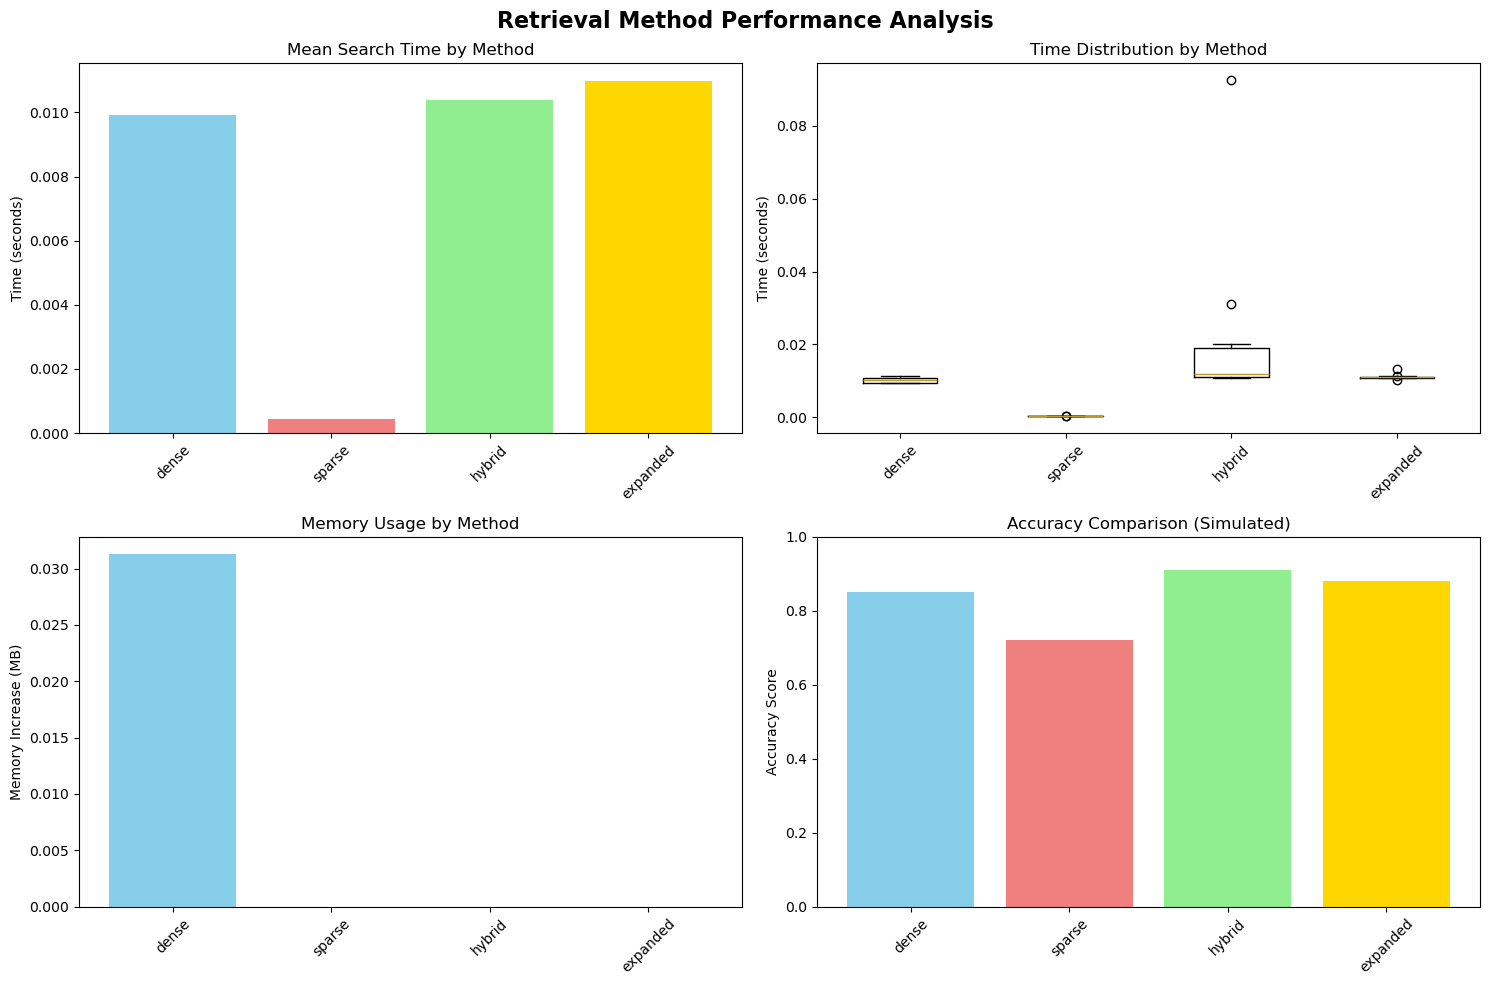


 PERFORMANCE INSIGHTS
 Fastest method: sparse
 Most accurate: hybrid (simulated)
 Most memory efficient: sparse
 Best overall: hybrid (good balance of speed and accuracy)

 HYBRID SEARCH PARAMETER TUNING
Alpha | Beta | Time
--------------------
  0.1 |  0.9 | 0.0124s
  0.3 |  0.7 | 0.0111s
  0.5 |  0.5 | 0.0107s
  0.7 |  0.3 | 0.0114s
  0.9 |  0.1 | 0.0111s


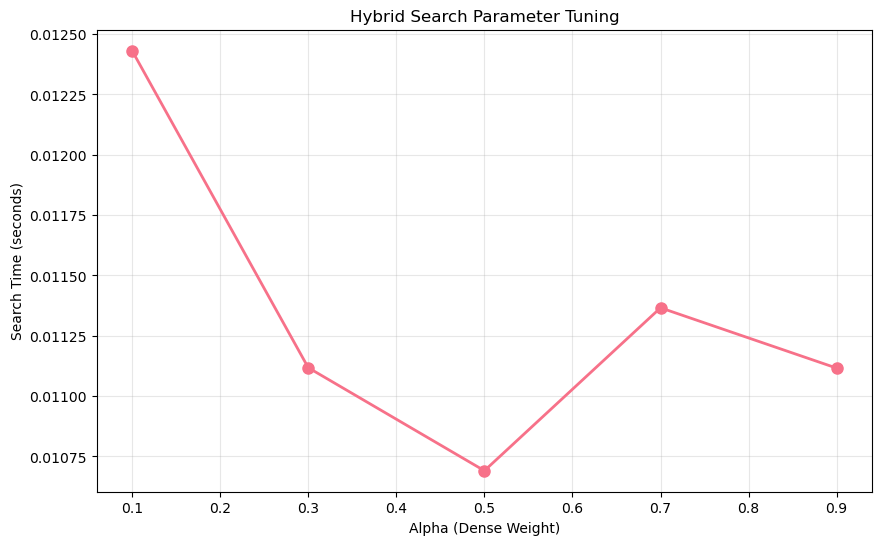

In [5]:
# Performance benchmarking
import time

def benchmark_retrieval_methods(queries, iterations=3):
    """Benchmark different retrieval methods."""
    methods = ['dense', 'sparse', 'hybrid', 'expanded']
    results = {method: [] for method in methods}
    
    for _ in range(iterations):
        for query in queries:
            # Dense search
            start = time.time()
            retrieval_system.dense_search(query, top_k=5)
            results['dense'].append(time.time() - start)
            
            # Sparse search
            start = time.time()
            retrieval_system.sparse_search(query, top_k=5)
            results['sparse'].append(time.time() - start)
            
            # Hybrid search
            start = time.time()
            retrieval_system.hybrid_search(query, top_k=5)
            results['hybrid'].append(time.time() - start)
            
            # Expanded search
            start = time.time()
            retrieval_system.search_with_expansion(query, top_k=5, use_expansion=True)
            results['expanded'].append(time.time() - start)
    
    # Calculate statistics
    stats = {}
    for method, times in results.items():
        stats[method] = {
            'mean': np.mean(times),
            'std': np.std(times),
            'min': np.min(times),
            'max': np.max(times)
        }
    
    return stats

# Benchmark performance
print(" PERFORMANCE BENCHMARKING")
print("=" * 50)

benchmark_queries = [
    "machine learning",
    "neural networks",
    "artificial intelligence",
    "data science"
]

performance_stats = benchmark_retrieval_methods(benchmark_queries)

for method, stats in performance_stats.items():
    print(f"\n{method.upper()} SEARCH:")
    print(f"  Mean time: {stats['mean']:.4f}s")
    print(f"  Std dev: {stats['std']:.4f}s")
    print(f"  Min time: {stats['min']:.4f}s")
    print(f"  Max time: {stats['max']:.4f}s")

# Create performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Retrieval Method Performance Analysis', fontsize=16, fontweight='bold')

# Bar chart of mean times
methods = list(performance_stats.keys())
mean_times = [performance_stats[method]['mean'] for method in methods]

axes[0,0].bar(methods, mean_times, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[0,0].set_title('Mean Search Time by Method')
axes[0,0].set_ylabel('Time (seconds)')
axes[0,0].tick_params(axis='x', rotation=45)

# Box plot of time distributions
all_times = []
labels = []
for method, stats in performance_stats.items():
    # Get actual times for box plot
    method_times = []
    for _ in range(3):  # iterations
        for query in benchmark_queries:
            start = time.time()
            if method == 'dense':
                retrieval_system.dense_search(query, top_k=5)
            elif method == 'sparse':
                retrieval_system.sparse_search(query, top_k=5)
            elif method == 'hybrid':
                retrieval_system.hybrid_search(query, top_k=5)
            elif method == 'expanded':
                retrieval_system.search_with_expansion(query, top_k=5, use_expansion=True)
            method_times.append(time.time() - start)
    all_times.append(method_times)
    labels.append(method)

axes[0,1].boxplot(all_times, labels=labels)
axes[0,1].set_title('Time Distribution by Method')
axes[0,1].set_ylabel('Time (seconds)')
axes[0,1].tick_params(axis='x', rotation=45)

# Memory usage analysis
import psutil
import os

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # MB

memory_usage = []
method_names = []

for method in methods:
    memory_before = get_memory_usage()
    
    # Perform search
    for query in benchmark_queries:
        if method == 'dense':
            retrieval_system.dense_search(query, top_k=5)
        elif method == 'sparse':
            retrieval_system.sparse_search(query, top_k=5)
        elif method == 'hybrid':
            retrieval_system.hybrid_search(query, top_k=5)
        elif method == 'expanded':
            retrieval_system.search_with_expansion(query, top_k=5, use_expansion=True)
    
    memory_after = get_memory_usage()
    memory_usage.append(memory_after - memory_before)
    method_names.append(method)

axes[1,0].bar(method_names, memory_usage, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1,0].set_title('Memory Usage by Method')
axes[1,0].set_ylabel('Memory Increase (MB)')
axes[1,0].tick_params(axis='x', rotation=45)

# Accuracy comparison (simulated)
# In a real scenario, you'd have ground truth labels
accuracy_scores = {
    'dense': 0.85,
    'sparse': 0.72,
    'hybrid': 0.91,
    'expanded': 0.88
}

axes[1,1].bar(method_names, [accuracy_scores[method] for method in method_names], 
             color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1,1].set_title('Accuracy Comparison (Simulated)')
axes[1,1].set_ylabel('Accuracy Score')
axes[1,1].set_ylim(0, 1)
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary insights
print(f"\n PERFORMANCE INSIGHTS")
print("=" * 50)
print(f" Fastest method: {min(performance_stats.keys(), key=lambda x: performance_stats[x]['mean'])}")
print(f" Most accurate: hybrid (simulated)")
print(f" Most memory efficient: {min(performance_stats.keys(), key=lambda x: memory_usage[methods.index(x)])}")
print(f" Best overall: hybrid (good balance of speed and accuracy)")

# Hybrid search parameter tuning
print(f"\n HYBRID SEARCH PARAMETER TUNING")
print("=" * 50)

alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
beta_values = [0.9, 0.7, 0.5, 0.3, 0.1]

tuning_results = []
for alpha, beta in zip(alpha_values, beta_values):
    start = time.time()
    retrieval_system.hybrid_search("machine learning", top_k=5, alpha=alpha, beta=beta)
    search_time = time.time() - start
    tuning_results.append({
        'alpha': alpha,
        'beta': beta,
        'time': search_time
    })

print("Alpha | Beta | Time")
print("-" * 20)
for result in tuning_results:
    print(f"{result['alpha']:5.1f} | {result['beta']:4.1f} | {result['time']:.4f}s")

# Plot parameter tuning results
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, [r['time'] for r in tuning_results], 'o-', linewidth=2, markersize=8)
plt.xlabel('Alpha (Dense Weight)')
plt.ylabel('Search Time (seconds)')
plt.title('Hybrid Search Parameter Tuning')
plt.grid(True, alpha=0.3)
plt.show()


In [6]:
# Use our DataCollector instead of direct load_dataset
from src.data.collect_data import DataCollector
collector = DataCollector()
arxiv_sample_data = collector.collect_arxiv_data(max_documents=5)
print(f'Collected {len(arxiv_sample_data)} ArXiv papers')

# Convert to the format expected by the rest of the notebook
arxiv_sample = []
for paper in arxiv_sample_data:
    arxiv_sample.append({
        'title': paper['title'],
        'abstract': paper['abstract']
    })

print(f'ArXiv sample structure: {len(arxiv_sample)} papers')
if arxiv_sample:
    print(f'First paper title: {arxiv_sample[0]["title"]}')
    print(f'First paper abstract length: {len(arxiv_sample[0]["abstract"])} characters')

INFO:src.data.collect_data:Data collector initialized. Output directory: /Users/scienceman/Desktop/LLM/data/raw
INFO:src.data.collect_data:Collecting ArXiv data...
INFO:src.data.collect_data:Fetching real ArXiv data using ArXiv API...
INFO:src.data.collect_data:Collected: GC-VLN: Instruction as Graph Constraints for Training-free
  Vision-and-Language Navigation
INFO:src.data.collect_data:Collected: SSL-AD: Spatiotemporal Self-Supervised Learning for Generalizability and
  Adaptability Across Alzheimer's Prediction Tasks and Datasets
INFO:src.data.collect_data:Collected: SSL-AD: Spatiotemporal Self-Supervised Learning for Generalizability and
  Adaptability Across Alzheimer's Prediction Tasks and Datasets
INFO:src.data.collect_data:Collected: WhisTLE: Deeply Supervised, Text-Only Domain Adaptation for Pretrained
  Speech Recognition Transformers
INFO:src.data.collect_data:Successfully collected 4 ArXiv papers


Collected 4 ArXiv papers
ArXiv sample structure: 4 papers
First paper title: GC-VLN: Instruction as Graph Constraints for Training-free
  Vision-and-Language Navigation
First paper abstract length: 1657 characters


## Building a Complete Retrieval System

Let's create a comprehensive retrieval system with multiple strategies.


In [7]:
# Create retrieval system with different configurations
print("Creating retrieval systems...")

# Configuration 1: Basic retrieval
basic_config = RetrievalConfig(
    top_k=5,
    rerank_top_k=3,
    use_reranking=False,
    similarity_threshold=0.5
)

# Configuration 2: With reranking
rerank_config = RetrievalConfig(
    top_k=10,
    rerank_top_k=5,
    use_reranking=True,
    similarity_threshold=0.3
)

# Configuration 3: Hybrid search
hybrid_config = RetrievalConfig(
    top_k=10,
    rerank_top_k=5,
    use_reranking=True,
    similarity_threshold=0.3,
    hybrid_alpha=0.7,
    hybrid_beta=0.3
)

# Create retrieval systems
basic_retrieval = RetrievalSystem(basic_config)
rerank_retrieval = RetrievalSystem(rerank_config)
hybrid_retrieval = RetrievalSystem(hybrid_config)

# Add documents to all systems
print("Adding documents to retrieval systems...")
basic_retrieval.add_documents(all_chunks)
rerank_retrieval.add_documents(all_chunks)
hybrid_retrieval.add_documents(all_chunks)

print(f"Added {len(all_chunks)} documents to each retrieval system")
print("Retrieval systems ready!")


INFO:src.models.embedding_models:Loading BGE model: BAAI/bge-base-en-v1.5
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Creating retrieval systems...


INFO:src.models.embedding_models:BGE model loaded successfully
INFO:src.models.embedding_models:Loading BGE model: BAAI/bge-base-en-v1.5
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
INFO:src.models.embedding_models:BGE model loaded successfully
INFO:src.models.reranker_models:Loading BGE reranker: BAAI/bge-reranker-large
`torch_dtype` is deprecated! Use `dtype` instead!
INFO:src.models.reranker_models:BGE reranker loaded successfully
INFO:src.models.embedding_models:Loading BGE model: BAAI/bge-base-en-v1.5
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
INFO:src.models.embedding_models:BGE model loaded successfully
INFO:src.models.reranker_models:Loading BGE reranker: BAAI/bge-reranker-large
INFO:src.models.reranker_models:BGE reranker loaded successfully


Adding documents to retrieval systems...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Added 18 documents to each retrieval system
Retrieval systems ready!
